<a href="https://colab.research.google.com/github/viswanathgs/Autodiff-Puzzles/blob/main/autodiff_puzzlers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autodiff Puzzles
- by [Sasha Rush](http://rush-nlp.com) - [srush_nlp](https://twitter.com/srush_nlp)


This is a set of puzzles  about getting better at autodifferentiation
It's a follow up to the [Tensor Puzzles](https://github.com/srush/Tensor-Puzzles).



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/srush/Autodiff-Puzzles/blob/main/autodiff_puzzlers.ipynb)



These puzzles are about grokking autodiff.
I give you a basic tensor-to-tensor function, and your goal is to give me the Jacobian.
If a function takes input a tensor of shape $I$ and outputs a tensor of shape $O$ the
Jacobian is a tensor of shape $(O, I)$  that contains each derivative $\frac{df(x)_o}{dx_i}$.
My recommendation is to work them out first with math and then think about how to write
this as a tensor function. It gets really hard.

## Rules and Tips

* Every answer is 1 line of 80-column code. Many of them can be done with 20 characters or so.
* Everything in these puzzles should be done basic operators, nothing fancy. You cannot call np.array, etc.
* Recall the basic multivariate calculus identities.

The visualization will show you $x$ and $f(x)$ as heat maps.
The spotlights show you what your current Jacobian looks like.

In [ ]:
# @title Library Code (hide)

!pip install -qqq beartype git+https://github.com/chalk-diagrams/chalx jaxtyping
import jax
import jax.numpy as np
import random
from chalk import square, make_path
import jax.numpy as np
import numpy as onp
from matplotlib import colormaps
import matplotlib.pyplot as plt
import chalk
import jax
from jaxtyping import Shaped
from matplotlib.colors import TwoSlopeNorm
from beartype import beartype as typechecker
from jaxtyping import jaxtyped
import IPython

Array = np.ndarray


v = plt.get_cmap("RdBu")


def matrix(mat, n, d=0):
    s = square(1)
    shape = mat.shape
    if len(shape) >= 2 + d:
        I, J = shape[-2:]
    else:
        I = 1
        (J,) = shape[-1:]
    norm = TwoSlopeNorm(
        vmin=np.minimum(mat.min(), -1), vcenter=0, vmax=np.maximum(1, mat.max())
    )
    d = s.translate(np.arange(I)[:, None], np.arange(J)).fill_color(
        v(norm(mat))[..., :3]
    )
    return (
        s.translate(np.arange(I)[:, None], np.arange(J))
        .fill_color(v(norm(mat))[..., :3])
        .named(n)
        .concat()
        .concat()
    )


def connect(d, n, m, j):
    a = d.get_subdiagram(n).get_envelope().center
    b = d.get_subdiagram(m).get_envelope().center[:, :, None, None]
    p = (
        chalk.Path.from_points(
            [
                a + chalk.tx.V2(0, (0.5 / a.shape[0]) * np.arange(a.shape[0])[:, None]),
                b - chalk.tx.V2(0.5, 0.5),
                b + chalk.tx.V2(-0.5, 0.5),
                a + chalk.tx.V2(0, (0.5 / a.shape[0]) * np.arange(a.shape[0])[:, None]),
            ],
            True,
        )
        .stroke()
        .fill_color(np.where(j[..., None] > 0, v([1.0])[..., :3], v([0.0])[..., :3]))
        .line_width(0)
        .fill_opacity(0.5 * np.abs(j) / np.max(np.abs(j)))
    )
    return p.concat().concat().concat().concat()


def check(f, jac, in_shape, in_shape2=None):
    fp_x = jax.jacrev(f, 0)
    if in_shape2 is not None:
        fp_y = jax.jacrev(f, 1)
    f = jaxtyped(typechecker=typechecker)(f)
    jac = jaxtyped(typechecker=typechecker)(jac)
    x = np.array(onp.random.random(in_shape) - 0.5)
    # x = np.linspace(0, 10, 10)
    # x = (np.random.random((3, 3)) - 0.5) * 10
    fail = False

    def show(j_check_x, j_x):
        for i, ind in enumerate(zip(*onp.array(~np.isclose(j_check_x, j_x)).nonzero())):
            print(
                "Fail at:",
                list(map(int, ind)),
                "Yours: ",
                j_x[ind],
                "True:",
                j_check_x[ind],
            )
            if i > 10:
                break

    if in_shape2 is not None:
        y = np.array(onp.random.random(in_shape2) - 0.5)
        # y = np.linspace(0, 10, 10)
        f_xy = f(x, y)
        j_check_x = fp_x(x, y)
        j_check_y = fp_y(x, y)
        j_x, j_y = jac(x, y)
        if not np.isclose(j_check_x, j_x).all():
            fail = True
            print("x check failed")
            show(j_check_x, j_x)

        if not np.isclose(j_check_y, j_y).all():
            fail = True
            print("y check failed")
            show(j_check_y, j_y)
        j2_x = j_x[None, :, None, :] if f_xy.ndim == 1 else j_x
        j2_y = j_y[None, :, None, :] if f_xy.ndim == 1 else j_y
    else:
        f_xy = f(x)
        j_x = jac(x)
        j_check_x = fp_x(x)
        if not np.isclose(j_check_x, j_x).all():
            print("x check failed")
            fail = True
            show(j_check_x, j_x)

        j2_x = j_x
        if f_xy.ndim == 1 and x.ndim == 1:
            j2_x = j_x[None, :, None, :]
        if f_xy.ndim == 1 and x.ndim == 2:
            j2_x = j_x[None, :, :, :]

    def matrix_with_translation(data, name, d=0, translate_x=0, translate_y=0):
        return matrix(data, name, d).translate(translate_x, translate_y)

    xd = matrix_with_translation(x, "x")
    fd = matrix_with_translation(f_xy, "f", translate_x=10)
    d = xd + fd
    conn_x = connect(d, "x", "f", j2_x)

    if in_shape2 is not None:
        yd = matrix_with_translation(y, "y", translate_y=12)
        d += yd
        conn_y = connect(d, "y", "f", j2_y)

    eps = x.max() / 5 if in_shape2 is None else max(x.max(), y.max()) / 5
    offset = np.array([0, 1, 2, 3, 2, 1, 0])[:, None, None] * eps
    x_mat = matrix_with_translation(x + offset, "x", d=1)

    if in_shape2 is not None:
        y_mat = matrix_with_translation(y + offset, "y", d=1, translate_y=12)
        f_mat = matrix_with_translation(
            f_xy + (j_x * offset).sum(-1)[:, None] + (j_y * offset).sum(-1)[:, None],
            "f",
            d=1,
            translate_x=10,
        )
        d = (x_mat + y_mat + f_mat) + conn_x + conn_y
    else:
        if x.ndim == 1:
            f_mat = matrix_with_translation(
                f_xy + (j_x * offset).sum(-1)[:, None], "f", d=1, translate_x=10
            )
        else:
            offset = offset[..., None]
            if f_xy.ndim == 2:
                offset = offset[..., None]
            f_mat = matrix_with_translation(
                f_xy + (j_x * offset).sum(-1).sum(-1),
                "f",
                d=1,
                translate_x=10,
            )
        d = (x_mat + f_mat) + conn_x

    d = chalk.rectangle(10, 10).fill_opacity(0).line_width(0) + d
    d.animate_svg("/tmp/out.svg", 512)
    IPython.display.display(IPython.display.SVG("/tmp/out.svg"))

    if not fail:
        show_dog()
    return  # .animate_svg("out.svg", 512)

def show_dog():
    print("Passed Tests!")
    pups = [
    "2m78jPG",
    "pn1e9TO",
    "MQCIwzT",
    "udLK6FS",
    "ZNem5o3",
    "DS2IZ6K",
    "aydRUz8",
    "MVUdQYK",
    "kLvno0p",
    "wScLiVz",
    "Z0TII8i",
    "F1SChho",
    "9hRi2jN",
    "lvzRF3W",
    "fqHxOGI",
    "1xeUYme",
    "6tVqKyM",
    "CCxZ6Wr",
    "lMW0OPQ",
    "wHVpHVG",
    "Wj2PGRl",
    "HlaTE8H",
    "k5jALH0",
    "3V37Hqr",
    "Eq2uMTA",
    "Vy9JShx",
    "g9I2ZmK",
    "Nu4RH7f",
    "sWp0Dqd",
    "bRKfspn",
    "qawCMl5",
    "2F6j2B4",
    "fiJxCVA",
    "pCAIlxD",
    "zJx2skh",
    "2Gdl1u7",
    "aJJAY4c",
    "ros6RLC",
    "DKLBJh7",
    "eyxH0Wc",
    "rJEkEw4"]
    IPython.display.display(IPython.display.HTML("""
    <video alt="test" controls autoplay=1>
        <source src="https://openpuppies.com/mp4/%s.mp4"  type="video/mp4">
    </video>
    """%(random.sample(pups, 1)[0])))

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Problem 1: Id

Warmup: $f(x_0) = [x_0]$

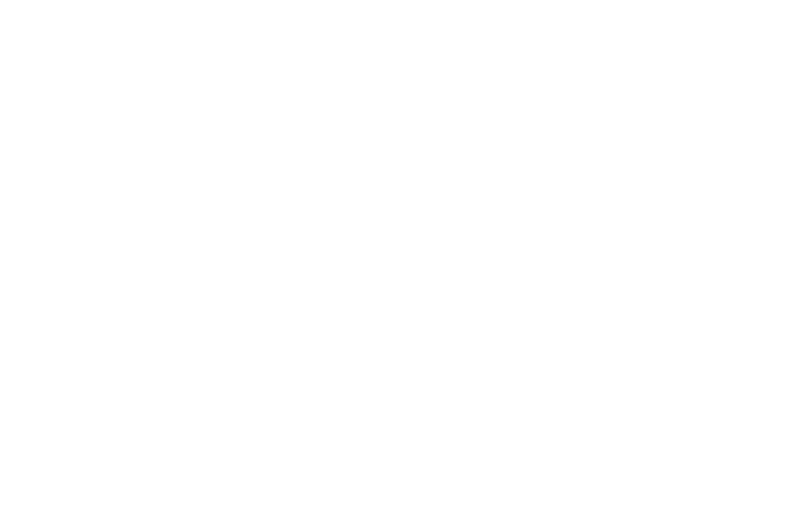

Passed Tests!


In [ ]:
Is = np.arange(1)


def f(x: Shaped[Array, "1"]) -> Shaped[Array, "1"]:
    return 2 * x


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "1 1"]:
    return 2 + Is[None, :]


check(f, jac, in_shape=Is.shape)

### Problem 2: Cosine

Warmup: $f(x_0) = [\cos(x_0)]$

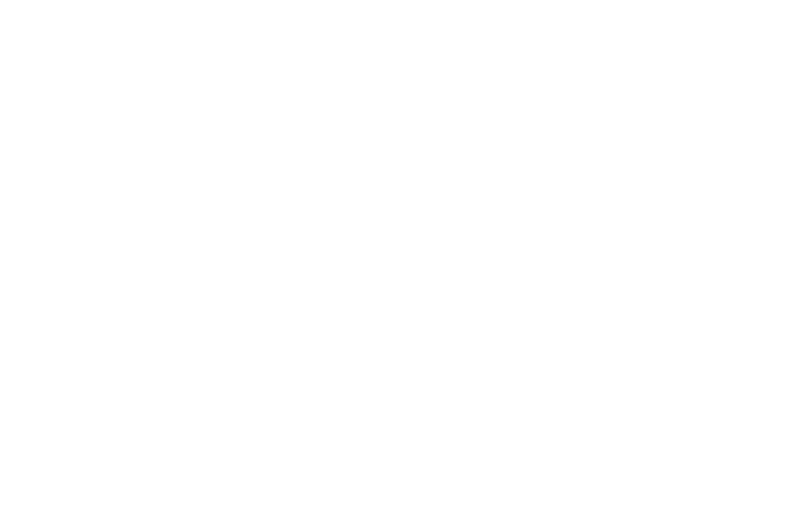

Passed Tests!


In [ ]:
def f(x: Shaped[Array, "1"]) -> Shaped[Array, "1"]:
    return np.cos(x)


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "1 1"]:
    return -np.sin(x) + Is[None, :]


check(f, jac, in_shape=1)

### Problem 3: Mean

$f(x_0, x_1, \ldots, x_{I-1}) = [(x_0 + x_1 + \ldots + x_{I-1}) / I]$

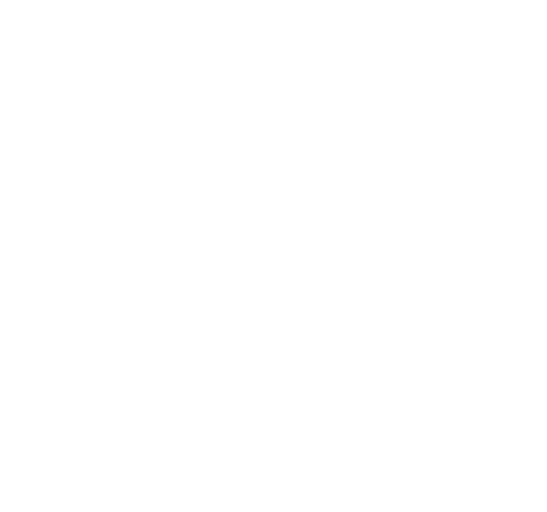

Passed Tests!


In [ ]:
I = 10
Is = np.arange(I)


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "1"]:
    return np.mean(x, axis=0, keepdims=True)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "1 I"]:
    return (Is - Is + 1)[None, :] / I


check(f, jac, in_shape=Is.shape)

### Problem 4: Product

$f(x_0, x_1, \ldots, x_{I-1}) = x_0 \times x_1 \times \ldots \times x_{I-1}$

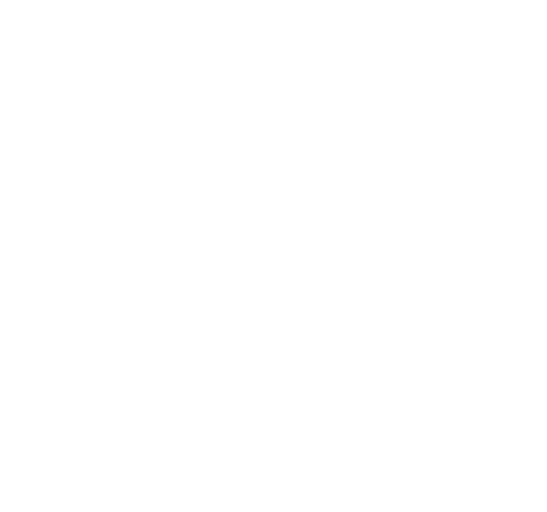

Passed Tests!


In [ ]:
def f(x: Shaped[Array, "I"]) -> Shaped[Array, "1"]:
    return np.prod(x, keepdims=True)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "1 I"]:
    return f(x) / x[None, :]


check(f, jac, in_shape=Is.shape)

### Problem 5: Repeat

$f(x_0) = [x_0, x_0,  x_0, \ldots  x_0]$

Hint: The function `dx` should return a scalar. It is the
derivative of $f(x_0)_o$, i.e. the o'th output.


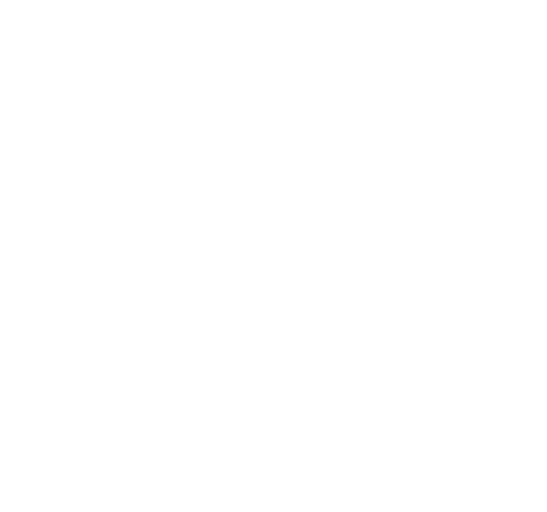

Passed Tests!


In [ ]:
Is = np.arange(1)
O = 10
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "1"]) -> Shaped[Array, "O"]:
    return (x + (Os * 0 + 1))[:, 0]


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "O 1"]:
    return Os - Os + 1


check(f, jac, in_shape=Is.shape)

### Problem 6: Repeat and Scale

$$f(x_0) = [x_0 \times 0/I, x_0 \times 1/I,  x_0 \times 2/I,  \ldots,  x_{0} \times (I-1)/I]$$

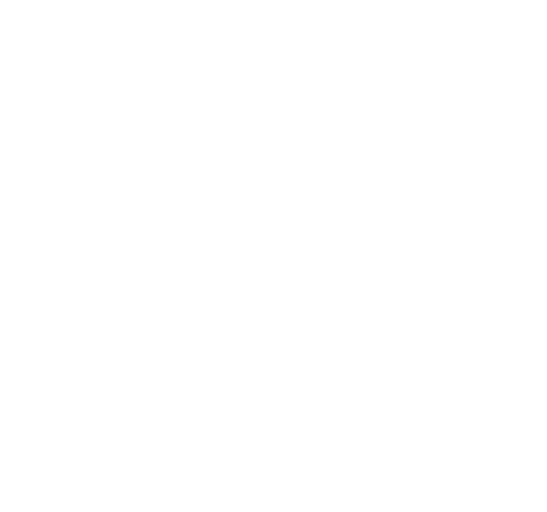

Passed Tests!


In [ ]:
Is = np.arange(1)
O = 10
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "1"]) -> Shaped[Array, "O"]:
    return x * (Os / O)[:, 0]


def jac(x: Shaped[Array, "1"]) -> Shaped[Array, "O 1"]:
    return Os / O


check(f, jac, in_shape=Is.shape)

## Problem 7: Negation

$$f(x_0, x_1, \ldots) = [-x_0, -x_1, \ldots, -x_{I-1}]$$

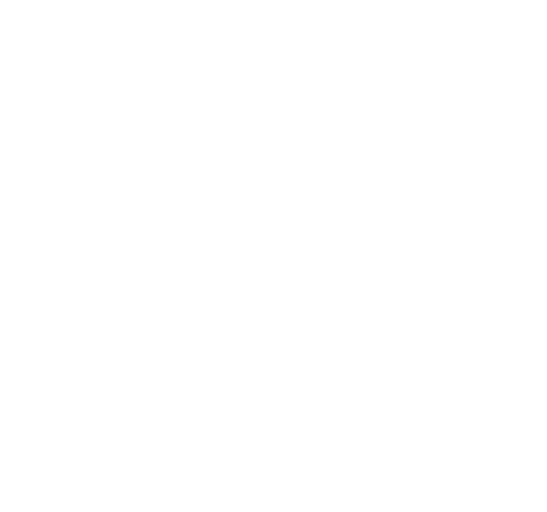

Passed Tests!


In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return -x


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return -1 * (Os == Is)


check(f, jac, in_shape=Is.shape)

## Problem 8: ReLU

$$f(x_0, x_1, \ldots) = [\text{relu}(x_0), \text{relu}(x_1), \ldots]$$

Recall

$$
\text{relu}(x) = \begin{cases}
0 & x < 0 \\
x & x >= 0
\end{cases}
$$

(Note: you can ignore the not of non-differentiability at 0.)

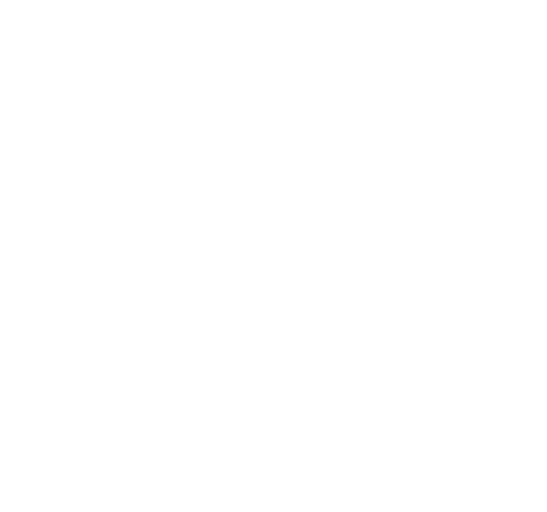

Passed Tests!


In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return x * (x > 0)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return (x > 0) * (Os == Is)


check(f, jac, in_shape=Is.shape)

## Problem 9: Index

$$f(x_0, x_1, \ldots, x_{24}) = [x_{10}, x_{11}, \ldots, x_{24}]$$



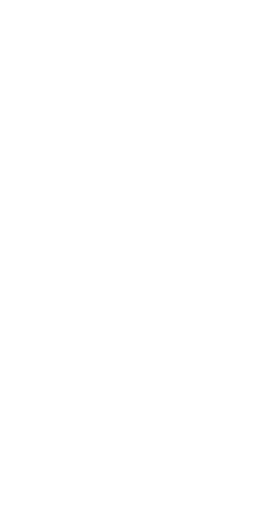

Passed Tests!


In [ ]:
I = 25
O = 15
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return x[10:]


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return Os + 10 == Is


check(f, jac, in_shape=Is.shape)

## Problem 10: Cumsum

$$f(x_0, x_1, \ldots) = [\sum^0_{i=0} x_{i}, \sum^1_{i=0} x_{i}, \sum^2_{i=0} x_{i}, \ldots, ] / 20$$



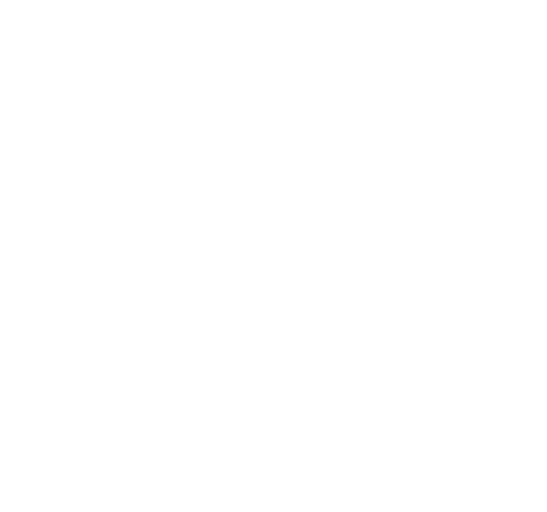

Passed Tests!


In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return np.cumsum(x) / 20


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return (Os >= Is) / 20


check(f, jac, in_shape=Is.shape)

## Problem 11: Running Mean


$$f(x_0, x_1, \ldots)_o = \frac{\displaystyle \sum^o_{i=o-W} x_i}{W}$$

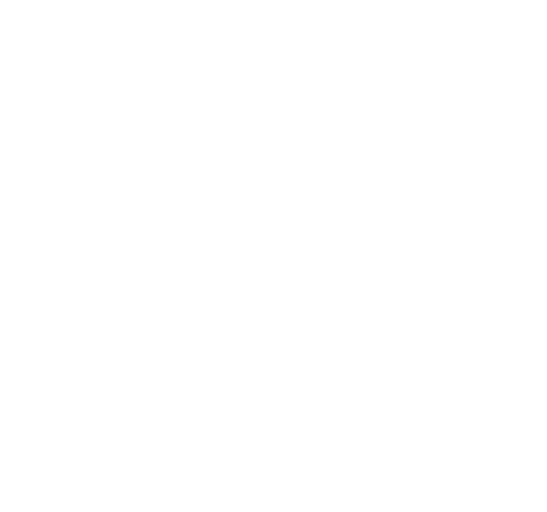

Passed Tests!


In [ ]:
I = 10
O = 8
Is = np.arange(I)
Os = np.arange(O)[:, None]
W = 3


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return np.convolve(x, np.ones(W) / W, mode="valid")


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return ((Os > Is - W) & (Os <= Is)) / W


check(f, jac, in_shape=Is.shape)

## Problem 12: Sort


$$f(x_0, x_1, \ldots) = \text{x's in sorted order}$$

You can use function like np.sort of this one.
(This one is a bit counterintuitive! Note that we are not asking you to differentiate the sorting function it self.)

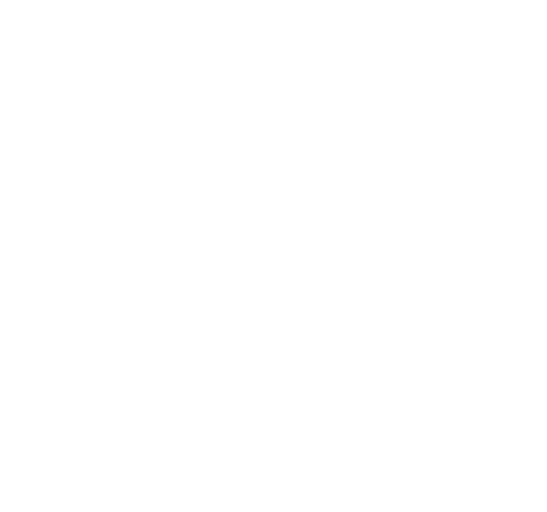

Passed Tests!


In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return np.sort(x)


def jac(x: Shaped[Array, "I"]) -> Shaped[Array, "O I"]:
    return 1 * (Os == Is)[np.argsort(x)]


check(f, jac, in_shape=Is.shape)

Next we move on to functions of two arguments. For these you will produce two derivatives: $$\frac{df(x, y)_o}{x_i}, \frac{df(x, y)_o}{y_j}$$. Everything else is the same.

## Problem 13: Elementwise mean

$$f(x, y)_o = (x_o + y_o) /2 $$

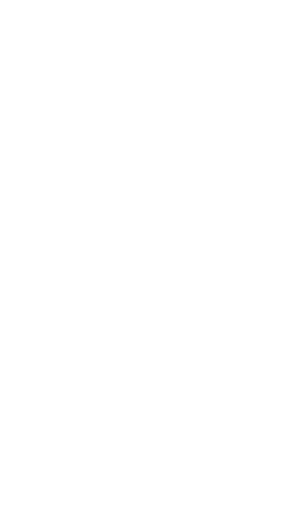

Passed Tests!


In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"], y: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return (x + y) / 2


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "I"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O I"]]:
    return (Os == Is) / 2, (Os == Is) / 2


check(f, jac, in_shape=Is.shape, in_shape2=Is.shape)

## Problem 14: Elementwise mul

$$f(x, y)_o = x_o * y_o $$

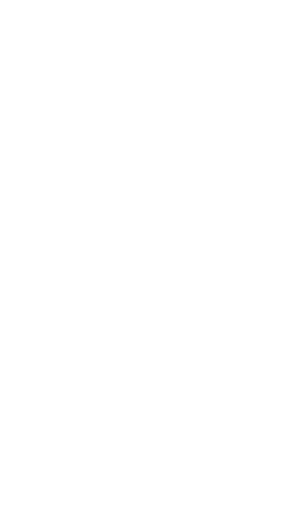

Passed Tests!


In [ ]:
I = 10
O = 10
Is = np.arange(I)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"], y: Shaped[Array, "I"]) -> Shaped[Array, "O"]:
    return x * y


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "I"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O I"]]:
    return y * (Os == Is), x * (Os == Is)


check(f, jac, in_shape=Is.shape, in_shape2=Is.shape)

## Problem 15: 1D Convolution

This is the standard 1D convolution used in deep learning. There is no wrap-around.

$$f(x, y)_o = \sum_{j=1}^K x_{o+j} * y_{j} / K $$

Note: This is probably the hardest one. The answer is short but tricky.

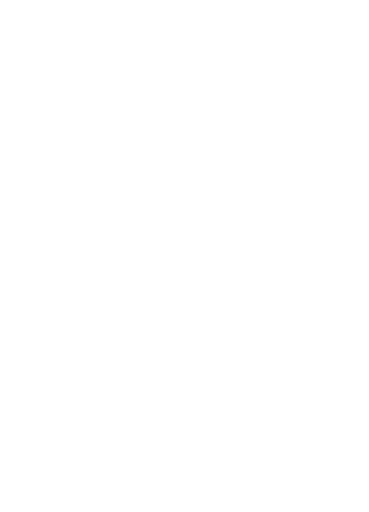

Passed Tests!


In [ ]:
I = 10
O = 6
W = 5
Is = np.arange(I)
Os = np.arange(O)[:, None]
Ws = np.arange(W)


def f(x: Shaped[Array, "I"], y: Shaped[Array, "W"]) -> Shaped[Array, "O"]:
    return np.convolve(x, y, mode="valid") / W


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "W"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O W"]]:
    return y[Os - Is - 1] / W * ((Os > Is - W) & (Os <= Is)), x[Os - Ws + W - 1] / W


check(f, jac, in_shape=Is.shape, in_shape2=Ws.shape)

## Problem 15: View

Compute the identity function for all $o,p$. $y$ is ignored.

$$f(X)_{o, p} = X_{o, p}$$

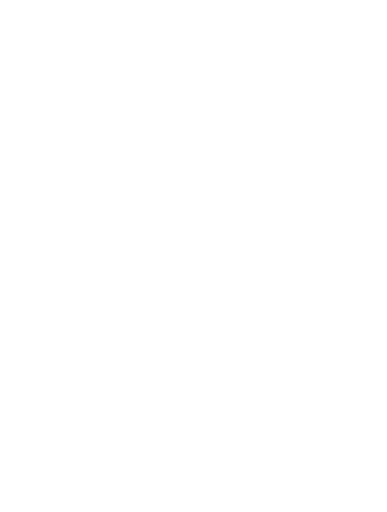

Passed Tests!


In [ ]:
I = 4
J = 4
O = 16
Is = np.arange(I)[:, None]
Js = np.arange(J)
Os = np.arange(O)[:, None, None]


def f(x: Shaped[Array, "I J"]) -> Shaped[Array, "O"]:
    return x.reshape((O,))


def jac(x: Shaped[Array, "I J"]) -> Shaped[Array, "O I J"]:
    return (Os // I == Is) & (Os % J == Js)


check(f, jac, in_shape=(I, J))

## Problem 16: Transpose

Transpose row and columns

$$f(X, y)_{o, p} = X_{p, o}$$


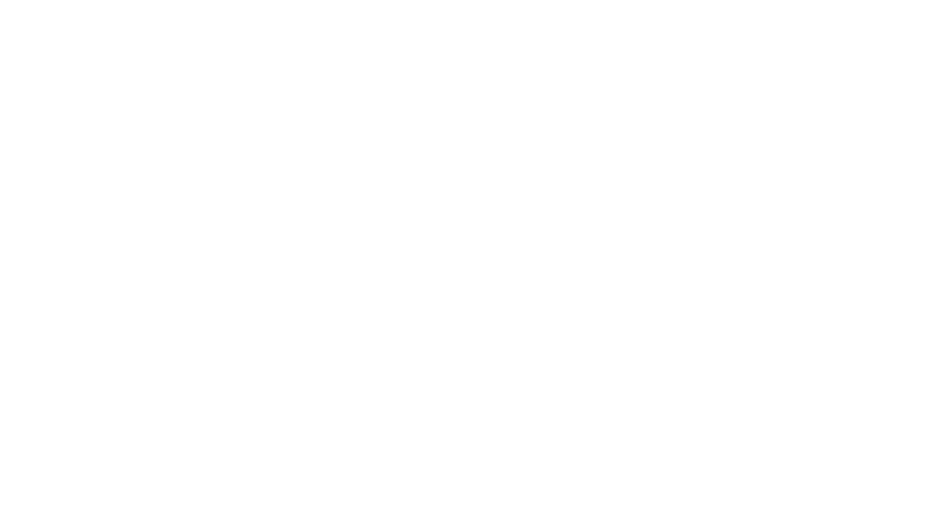

Passed Tests!


In [ ]:
I = 4
J = 4
O = 4
P = 4
Is = np.arange(I)[:, None]
Js = np.arange(J)
Os = np.arange(O)[:, None, None]
Ps = np.arange(P)[:, None, None, None]


def f(x: Shaped[Array, "I J"]) -> Shaped[Array, "O P"]:
    return x.T


def jac(x: Shaped[Array, "I J"]) -> Shaped[Array, "O P I J"]:
    return (Os == Is) & (Ps == Js)


check(f, jac, in_shape=(I, J))

## Problem 18: Mean Reduce

Compute the mean over rows

$$f(X, y)_{o, p} = \sum_{i} X_{i, p} / R$$


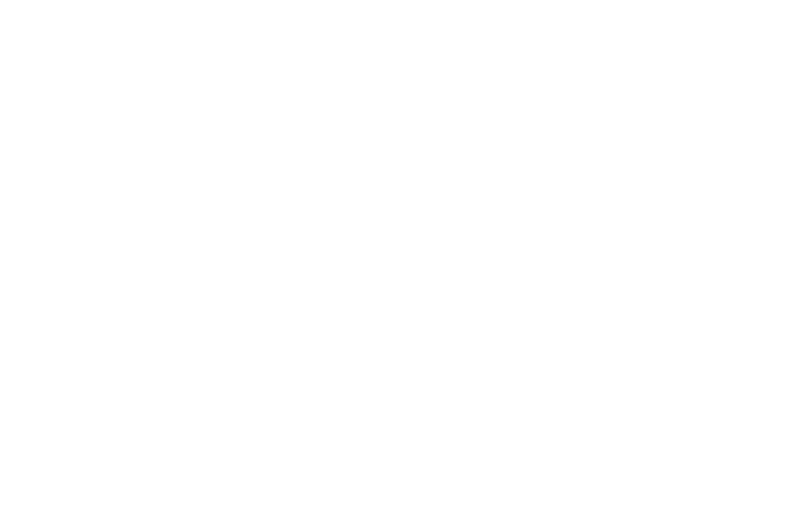

Passed Tests!


In [ ]:
I = 4
J = 4
O = 4
Is = np.arange(I)[:, None]
Js = np.arange(J)
Os = np.arange(O)[:, None, None]


def f(x: Shaped[Array, "I J"]) -> Shaped[Array, "O"]:
    return np.mean(x, axis=0)


def jac(x: Shaped[Array, "I J"]) -> Shaped[Array, "O I J"]:
    return ((Os == Js) & (Os + Is >= 0)) / I


check(f, jac, in_shape=(I, J))

## Problem 19: Matmul as vectors

Standard matrix multiplication

$$f(X, Y)_{o,p} = \sum_j X_{o, j} Y_{j,p}$$


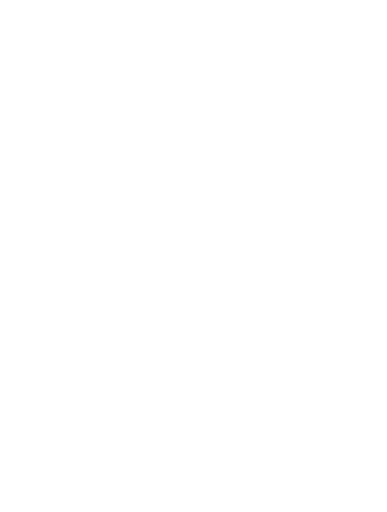

Passed Tests!


In [ ]:
I = 4
J = 4
O = 4
Is = np.arange(I)
Js = np.arange(J)
Os = np.arange(O)[:, None]


def f(x: Shaped[Array, "I"], y: Shaped[Array, "J"]) -> Shaped[Array, "O "]:
    return (x.reshape(2, 2) @ y.reshape(2, 2)).reshape(O)


def jac(
    x: Shaped[Array, "I"], y: Shaped[Array, "J"]
) -> tuple[Shaped[Array, "O I"], Shaped[Array, "O J"]]:
    # (Os // 2 == Is // 2) and (Os % 2 == Js % 2) achieve masking
    # y.reshape(2, 2)[Is % 2, Os % 2] and x.reshape(2, 2)[Os // 2, Js // 2] achieve selection
    return y.reshape(2, 2)[Is % 2, Os % 2] * (Os // 2 == Is // 2), x.reshape(2, 2)[Os // 2, Js // 2] * (Os % 2 == Js % 2)


check(f, jac, in_shape=Is.shape, in_shape2=Js.shape)